# Assignment #1: Face Recognition

---

## Group Members

| Name          | ID      |
|---------------|---------|
| Patrick George Kromil Shenouda     | 20010383  |
| Adel Mahmoud Mohamed Abdelrahman    | 20010769  |
| Mahmoud Attia Mohamed Abdelaziz | 20011810    |

---

## Problem Statement

We aim to perform face recognition, a task that involves identifying the subject in a given image. Our database consists of 40 subjects, and we will outline the necessary steps to achieve the goal of this assignment.

---


## 1. Download the Dataset and Understand the Format

a. ORL dataset is available at the following link.
https://www.kaggle.com/kasikrit/att-database-of-faces/

b. The dataset has 10 images per 40 subjects. Every image is a grayscale
image of size 92x112.

---

needed imports

In [ ]:
import cv2
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import sklearn.decomposition
import time
from scipy import linalg
import matplotlib.pyplot as plt
import torch
import pandas as pd

unzip the uploaded archieve zipped file

In [ ]:
# !unzip archive.zip -d /content/archive/
# !unzip non-face-archive.zip -d /content/non-face-archive/

In [ ]:
archive = "/content/archive"
non_face_training_archive = "/content/non-face-archive/non-face-archive/non-face-training"
non_face_testing_archive = "/content/non-face-archive/non-face-archive/non-face-test"

## 2. Generate the Data Matrix and the Label vector (2.5 Points)

a. Convert every image into a vector of 10304 values corresponding to the
image size.

b. Stack the 400 vectors into a single Data Matrix D and generate the label
vector y. The labels are integers from 1:40 corresponding to the subject
id.

---

generate the data matrix and its corresponding label vector by reading the 10 images of each subject of the 40 subjects. Use flatten to convert every image from an image of size 92x112 into a vector of 10304 where each pixel represents a feature. label vector values are between 1 and 40 correspond to the id of each subject in the data matrix.

In [ ]:
def generate_data_label(archive_folder):
    data = []
    label = []
    for i in range(40):
        folder = os.path.join(archive_folder, "s" + str(i + 1))
        for j in range(10):
            path = os.path.join(folder, str(j+1) + ".pgm")
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                data.append(img.flatten())
                label.append(i + 1)
    return np.array(data), np.array(label)

## 3. Split the Dataset into Training and Test sets (2.5 Points)

a. From the Data Matrix D400x10304 keep the odd rows for training and
the even rows for testing. This will give you 5 instances per person for
training and 5 instances per person for testing.

b. Split the labels vector accordingly.


Split the data matix into training and test sets withing their corresponding labels by keeping the odd rows for training and the even rows for testing.


In [ ]:
def get_training_and_test(data, label):
    testing_data = data[::2]
    testing_label = label[::2]
    training_data = data[1::2]
    training_label = label[1::2]
    return training_data, training_label, testing_data, testing_label

In [ ]:
# Define a function to split data based on a condition
def split_data_conditionally(data, labels, is_half):
    if is_half:
        return get_training_and_test(data, labels)
    else:
        return get_diff_training_test(data, labels)



---



## Principal Component Analysis (PCA) Algorithm Overview

In this section, we applied the PCA (Principal Component Analysis) algorithm to obtain the projection matrix, which is essential for capturing the principal components that retain the most information or variance of the data while reducing its dimensionality.

1. **Data Preprocessing**: We started by centering the data, ensuring that the mean of each feature across the dataset is zero. This step is crucial for PCA as it eliminates any bias in the data and focuses solely on its variance.

2. **Eigenvalue and Eigenvector Calculation**: Instead of using the conventional method involving the covariance matrix, we opted for the Singular Value Decomposition (SVD) of the centralized data matrix \( Z \). This approach is more computationally efficient, especially for high-dimensional data, as it directly yields the eigenvalues and eigenvectors.

3. **Sorting and Selection**: We sorted the eigenvalues and their corresponding eigenvectors in descending order based on the eigenvalues. This step allows us to prioritize the principal components that capture the highest variance in the data.

4. **Determining the Number of Components**: We iteratively selected the principal components, starting from the first one, and continued adding additional components until we reached a threshold \( \alpha \). This threshold represents the fraction of total variance that we aim to retain in the reduced-dimensional space.

5. **Utilizing SVD**: By leveraging the SVD decomposition of \( Z \), we achieved a faster computation of eigenvalues and eigenvectors compared to traditional methods. This optimization significantly reduces the computational complexity, making the PCA algorithm more scalable for large datasets.

In [ ]:
def PCA(D, alpha):
    n = len(D)
    d = len(D[0])
    mean_vector = np.mean(D, axis=0)
    Z = D - mean_vector

    # cov_mat = (1 / n) * np.dot(Z.T, Z)
    # eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    # faster way to get the eigen values and vectors using SVD decomposition
    # Compute Singular Value Decomposition (SVD)
    U, s, Vt = np.linalg.svd(Z, full_matrices=False)
    # Compute eigenvectors (Principal Components)
    eigen_vectors = Vt.T
    # Compute eigenvalues
    eigen_values = (1 / n) * (s ** 2)

    # Obtain the indices to sort eigenvalues in descending order
    idx = eigen_values.argsort()[::-1]
    # Sort eigenvalues and eigenvectors accordingly
    sorted_eigenvalues = eigen_values[idx]
    sorted_eigenvectors = eigen_vectors[:, idx]

    total_variance = np.sum(sorted_eigenvalues)
    sub_variance = 0
    for r in range(len(sorted_eigenvalues)):
        sub_variance += sorted_eigenvalues[r]
        fr = sub_variance / total_variance
        if fr >= alpha:
            return sorted_eigenvectors[:, :r + 1]

    return sorted_eigenvectors

b. Project the training set, and test sets separately using the same
projection matrix.

c. Use a simple classifier (first Nearest Neighbor to determine the class
labels).

## PCA-based Classification using k-NN Classifier

In this section, we performed classification using the PCA (Principal Component Analysis) algorithm in combination with the k-NN (k-Nearest Neighbors) classifier. The following steps were undertaken:

### Projection of Training and Test Sets

1. **Data Preprocessing**: Initially, the training and test sets were prepared by splitting the dataset according to a specified condition, which can be adjusted based on the requirement (e.g., using half of the data for training and the other half for testing).
   
2. **Standardization**: Both the training and test sets were standardized using the `StandardScaler` to ensure that each feature had a mean of zero and unit variance. This step is essential for PCA as it minimizes the effect of differing scales among the features.

3. **PCA Transformation**: The PCA algorithm was applied to the standardized training set to obtain the projection matrix \( U_r \). This matrix captures the principal components that retain the most variance in the data while reducing its dimensionality. The parameter \( \alpha \) determines the fraction of total variance to be retained.

4. **Projection**: The projection matrix \( U_r \) obtained from the training set was then used to project both the training and test sets separately. This transformation ensures that the same reduced-dimensional space is used for both training and testing, maintaining consistency across the datasets.

### Classification with k-NN Classifier

5. **k-NN Classification**: The k-NN classifier was employed to classify the samples in the projected test set. This classifier assigns labels to test samples based on the majority vote of their \( k \) nearest neighbors in the training set. The choice of \( k \) influences the classifier's performance and can be tuned accordingly.

6. **Accuracy Calculation**: The accuracy of the classification was computed by comparing the predicted labels with the true labels of the test set. This metric indicates the percentage of correctly classified samples out of the total number of samples in the test set.

Overall, by combining PCA for dimensionality reduction and the k-NN classifier for classification, we constructed a robust classification pipeline capable of efficiently handling high-dimensional data and achieving accurate predictions.


In [ ]:
def test_pca(alpha, k, isHalf=True):
    D, y = generate_data_label(archive)
    D_training, y_training, D_testing, y_testing = split_data_conditionally(D, y, isHalf)
    start = time.time()
    Ur = PCA(D_training, alpha)
    end = time.time()
    print("PCA time:", (end - start), " sec")

    projected_D_training = np.dot(D_training, Ur)
    projected_D_testing = np.dot(D_testing, Ur)

    # in case of multiple k's are passed to the function, we don't have to
    # compute the model all over again
    accuracy = []
    for i in range(len(k)):
      knn_classifier = KNeighborsClassifier(n_neighbors=k[i])
      knn_classifier.fit(projected_D_training, y_training)
      y_pred = knn_classifier.predict(projected_D_testing)
      accuracy.append(knn_classifier.score(projected_D_testing, y_testing))

    return accuracy

d. Report Accuracy for every value of alpha separately.

e. Can you find a relation between alpha and classification accuracy?

In [ ]:
def alpha_compare(isHalf = True):
  pca_accuracy = []
  for alpha in [0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1]:
      accuracy = test_pca(alpha, [1], isHalf)[0]
      pca_accuracy.append(accuracy)
  return pca_accuracy

PCA time: 0.5666923522949219  sec
PCA time: 0.5056788921356201  sec
PCA time: 0.5523293018341064  sec
PCA time: 0.5325915813446045  sec
PCA time: 0.5017139911651611  sec
PCA time: 0.5080733299255371  sec
PCA time: 0.5134541988372803  sec
PCA time: 0.49399328231811523  sec
PCA time: 0.5149626731872559  sec


PCA tabulated results:
   alpha Value  50% split Accuracy
0         0.60               0.905
1         0.65               0.915
2         0.70               0.920
3         0.75               0.925
4         0.80               0.930
5         0.85               0.940
6         0.90               0.945
7         0.95               0.935
8         1.00               0.945


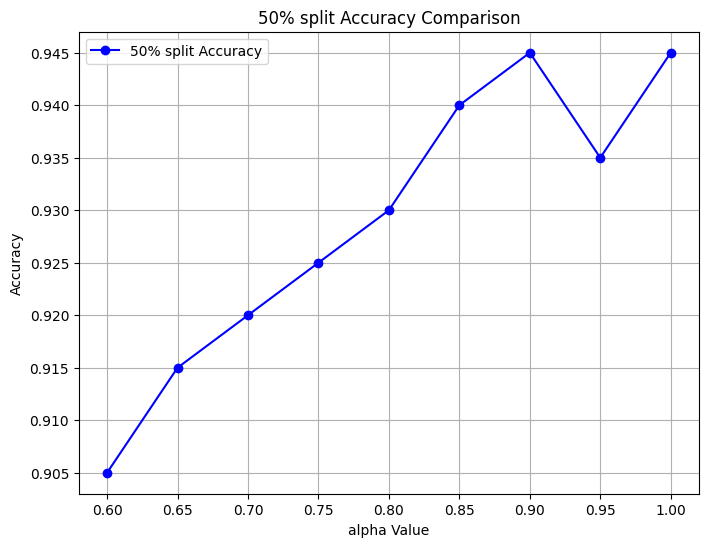

In [ ]:
alpha = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1]
half_split_accuracy = alpha_compare(1)

print("\n\nPCA tabulated results:")
# Create a pandas DataFrame to display the results
results_df = pd.DataFrame({
    'alpha Value': alpha,
    '50% split Accuracy': half_split_accuracy,
})

# Print the DataFrame
print(results_df)

# accuracies together
plt.figure(figsize=(8, 6))
plt.plot(alpha, half_split_accuracy, marker='o', label='50% split Accuracy', color='blue')
plt.title('50% split Accuracy Comparison')
plt.xlabel('alpha Value')
plt.ylabel('Accuracy')
plt.xticks(alpha)
plt.grid(True)
plt.legend()
plt.show()

**From the previous results we can conclude that:**
* As alpha increases, the classification accuracy generally tends to increase.
* There seems to be an optimal range of alpha values (around 0.9) where the classification accuracy peaks.
* There is observed decrease in accuracy despite the increase in alpha 0.95 and could be attributed to several factors and a possible factor of them is:
 * **Overfitting**: As alpha increases, more principal components are retained, leading to a higher risk of overfitting, especially if the dataset is relatively small. Overfitting occurs when the model captures noise or random fluctuations in the training data, which may not generalize well to unseen data, resulting in decreased accuracy on the test set.
* However, it's essential to note that this relations may vary depending on the dataset and the specific problem being addressed.



---



## 5. Classification Using **LDA** (30 Points)
a. Use the pseudo code below for LDA.

b. Project the training set, and test sets separately using the same
projection matrix U. You will have 39 dimensions in the new space.



## Linear Discriminant Analysis (LDA) Algorithm Overview

In this section, we applied the Linear Discriminant Analysis (LDA) algorithm to obtain the projection matrix, which is essential for getting the basis for the new space which is supposed to maximize the fisher LDA function by maximizing the difference between the projected means, and minimizing the variance of the projected data.


1. **Data Classification**: in this step the whole training data **(D)** is classified by getting all the observations belonging to the same class in the same list, and the code is general for any type of labels, you just have to pass the training data set, and the labels vector.

2. **The Between and the Within-Class scatter matrices calculations:**the calculations are done according to the pseudo code, and they are of course positive semidefinite symmetric matrices,they're both calculated in the same loop to improve the speed of the algorithm, and to get the nd array cast of the classes once and for all.

3. **Eigenvalue and Eigenvector Calculation**: We've used **PyTorch** to get the eigenvalue and vector decomposition and the reason for that is that it's a bit faster than **NumPy**

3. **Sorting and Selection**: We sorted the eigenvalues and their corresponding eigenvectors in descending order based on the eigenvalues **with respect to the absolute values of the eigen values** because the matrix of transformation is not positive semidefinite nor symmetric here and the value of the eigen value is what matters not it's sign because the sign means that it's in the reverse direction, and then the eigen vectors corresponding to the largest 39 eigen values-after sorting of course- are selected to be our new basis.

4. **Retruning the new basis**: at the end of the algorithm only 39 eigen vactors are returned and that corresponds to k-1 where k is the number of classes which is 40, **why 39?** because this is the maximum number of linearly independent eigen vectors in the set of eigen vectors, and to avoid overfitting of the data.



In [ ]:
def LDA(D, labels):
    D = np.array(D)
    distinct_labels = np.unique(labels)
    n_classes = len(distinct_labels)
    d = D.shape[1]

    # Initialize an empty list to store class-wise data
    class_wise_D = []

    # Iterate over unique labels
    for label in distinct_labels:
        # Select rows from D where the label matches, and append it to the class_wise_D
        class_wise_D.append(D[labels == label].tolist())

    # Now we get Sb (the between class scatter matrix) = sum over all the classes(nk . (Mk - M).(Mk-M))
    # And we get S as well in the same loop, to get the np array for each class once and for all
    Sb = np.zeros((d, d))
    S = np.zeros((d, d))

    # Getting the overall mean
    over_all_sample_mean = np.mean(D, axis=0)

    for i in range(n_classes):
        # for each class we need to parse it to np array and get it's mean
        class_ndarray = np.array(class_wise_D[i])
        class_mean = np.mean(class_ndarray, axis=0)

        # The Sb part
        tmp_difference_vec = class_mean - over_all_sample_mean
        Sb += (len(class_ndarray) * np.outer(tmp_difference_vec, tmp_difference_vec))

        # The S part
        class_z = class_ndarray - class_mean
        S += np.dot(class_z.T, class_z)

    # Convert to PyTorch tensors
    S = torch.tensor(S)
    Sb = torch.tensor(Sb)

    # S = cp.array(S)
    # Sb = cp.array(Sb)

    # Compute the pseudo-inverse of S and then matrix multiplication
    matrix_of_transformation = torch.matmul(torch.linalg.pinv(S), Sb)
    # matrix_of_transformation = cp.dot(cp.linalg.pinv(S), Sb)

    # matrix_of_transformation = torch.tensor(matrix_of_transformation)
    # Getting the eigenvalues and vectors
    eigenvalues, eigenvectors = torch.linalg.eig(matrix_of_transformation)

    # Convert eigenvalues and eigenvectors to NumPy arrays
    eigenvalues = eigenvalues.numpy()
    eigenvectors = eigenvectors.numpy()

    # Obtain the indices to sort eigenvalues in descending order of their absolute values
    idx = np.abs(eigenvalues).argsort()[::-1]

    # Sort eigenvalues and eigenvectors accordingly
    sorted_eigenvalues = eigenvalues[idx]
    sorted_eigenvectors = eigenvectors[:, idx]

    # Then we need to use our first n_classes - 1 eigen vectors to use them as
    return sorted_eigenvectors[:, :n_classes - 1]

c. Use a simple classifier (first Nearest Neighbor to determine the class
labels).



This function uses KNN classifier with k as an argument, and we've used it just like the same way above at the PCA section

In [ ]:
def test_lda(k, isHalf=True):
    D, y = generate_data_label(archive)
    D_training, y_training, D_testing, y_testing = split_data_conditionally(D, y, isHalf)


    # Getting the basis of the new space
    Ur = LDA(D_training, y_training)

    # project the training data using LDA on the new basis
    projected_D_training = np.dot(D_training, Ur)

    # project the testing data using LDA on the new basis
    projected_D_testing = np.dot(D_testing, Ur)

    projected_D_training = np.real(projected_D_training)
    projected_D_testing = np.real(projected_D_testing)

    # in case of multiple k's are passed to the function, we don't have to
    # compute the model all over again
    accuracy = []
    for i in range(len(k)):
      knn_classifier = KNeighborsClassifier(n_neighbors=k[i])
      knn_classifier.fit(projected_D_training, y_training)
      y_pred = knn_classifier.predict(projected_D_testing)
      accuracy.append(knn_classifier.score(projected_D_testing, y_testing))

    return accuracy

d. Report accuracy for the multiclass LDA on the face recognition
dataset.

In [ ]:
# print("LDA Accuracy (when using the nearest neighbour at k = 1): ", test_lda([1])[0])

LDA Accuracy (when using the nearest neighbour at k = 1):  0.96



 e. Compare the results to PCA results.


*   LDA accuracy at k = 1 was **0.96**
*   PCA accuracy at same k and at alpha = 0.95 was **0.935**





---



## 6. Classifier Tuning (20 Points)
a. Set the number of neighbors in the K-NN classifier to 1,3,5,7.

b. Tie breaking at your preferred strategy.

c. Plot (or tabulate) the performance measure (accuracy) against the
K value. This is to be done for PCA and LDA as well.


## Tie Breaking Strategy:
In scikit-learn's KNeighborsClassifier, the tie-breaking strategy is implicitly defined by the algorithm itself. By default, when there's a tie in the classification decision (i.e., when multiple classes have the same number of nearest neighbors), scikit-learn's K-NN classifier will automatically break the tie using the class label that appears first in the sorted list of class labels.

for example:

we have the following distances to the nearest neighbors and their corresponding class labels:

| Distance    | Class |
|-------------|-------|
| 1.5         | 1     |
| 2.0         | 2     |
| 2.0         | 2     |
| 2.5         | 1     |
| 2.5         | 3     |

In this case, we have a tie between classes 1 and 2 because they both have two nearest neighbors. Scikit-learn's KNeighborsClassifier will sort the class labels in ascending order: 1, 2, 3. Since 1 is the smallest label, it will be assigned as the predicted label for the query point.

In [ ]:
def k_classifier_compare():
    pca_accuracy = []
    lda_accuracy = []
    k_values = [1, 3, 5, 7]

    # Getting the accuracies for PCA
    pca_accuracy = test_pca(0.8, k_values)

    # Getting the accuracies for LDA
    lda_accuracy = test_lda(k_values)

    print("\n\ntabulated results:")
    # Create a pandas DataFrame to display the results
    results_df = pd.DataFrame({
        'K Value': k_values,
        'PCA Accuracy': pca_accuracy,
        'LDA Accuracy': lda_accuracy
    })
    print()
    print()
    # Print the DataFrame
    print(results_df)

    # Plot PCA accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, pca_accuracy, marker='o', label='PCA Accuracy', color='blue')
    plt.title('PCA Accuracy vs. K Value')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot LDA accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, lda_accuracy, marker='o', label='LDA Accuracy', color='red')
    plt.title('LDA Accuracy vs. K Value')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot PCA and LDA accuracies together
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, pca_accuracy, marker='o', label='PCA Accuracy', color='blue')
    plt.plot(k_values, lda_accuracy, marker='o', label='LDA Accuracy', color='red')
    plt.title('PCA vs. LDA Accuracy Comparison')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    plt.show()

d:  10304
r:  38
PCA time: 0.48841190338134766  sec


tabulated results:


   K Value  PCA Accuracy  LDA Accuracy
0        1         0.920         0.960
1        3         0.840         0.885
2        5         0.825         0.905
3        7         0.760         0.920


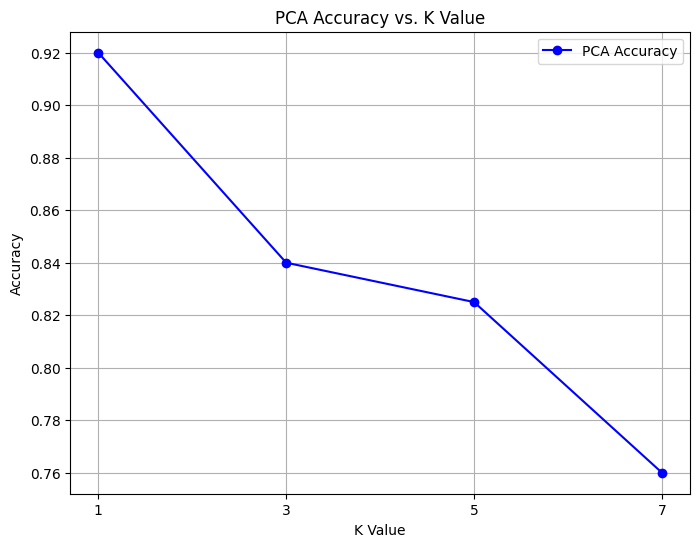

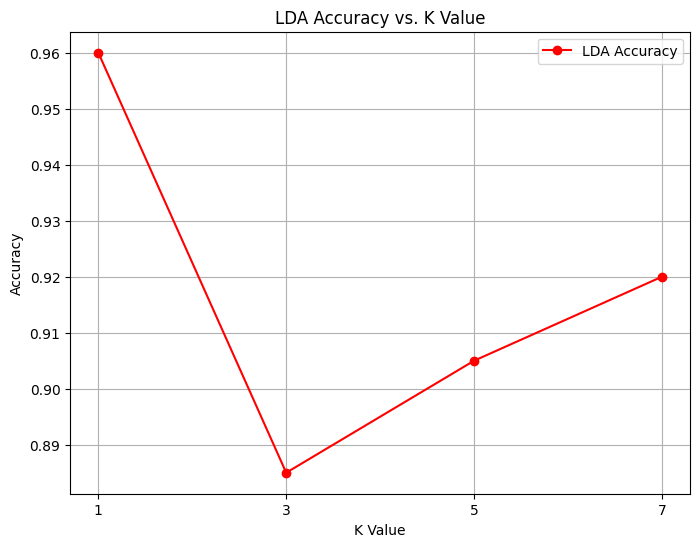

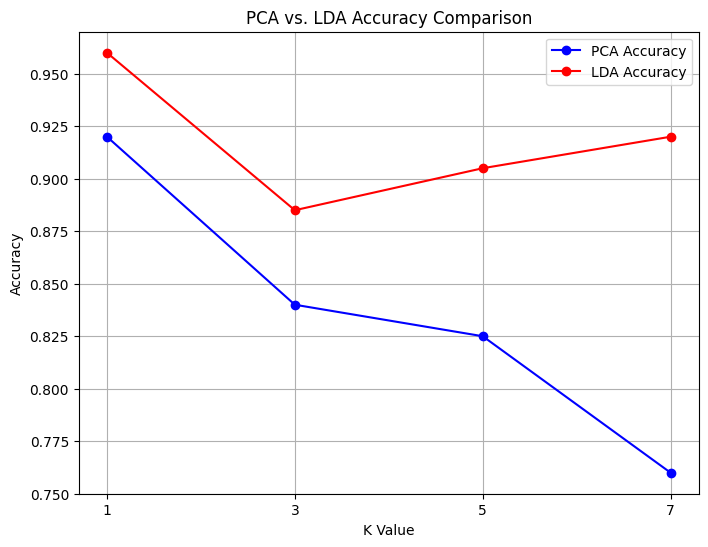

In [ ]:
# k_classifier_compare()

**Impact on Face Recognition:**

1. In face recognition task, increasing $k$ can cause the classifier to rely on a larger number of neighboring samples, potentially including samples from different classes that are similar to the query sample.
2. For face images, where subtle variations in facial features distinguish different individuals, including neighbors from other classes can introduce confusion and misclassification.
3. Additionally, as $k$ increases, the influence of noisy or outlier samples in the neighborhood also grows, leading to erroneous classifications.





---




# 7. Compare vs Non-Face Images (15 Points)
a. Download non-face images and make them of the same size 92x112.
and try to solve the classification problem faces vs. non-faces.

* i. Show failure and success cases.

* ii. How many dominant eigenvectors will you use for the LDA
solution?

      ans: here we will use 1 dominant eigen vector as number of classes = 2 (face/ non-face)
* iii. Plot the accuracy vs the number of non-faces images while fixing
the number of face images.

* iv. Criticize the accuracy measure for large numbers of non-faces
images in the training data.

* In this part we downloaded a non-face data set and divided it into training and testing sets and mege the face traing set with the non face traing set, and do the same for the face and non face testing sets.
* Then used PCA/LDA dim reduction algorithm to get the projection matrix Ur.
* Then project the data using Ur and use KNN classifier to fit the trainging data and predict the testing data and get its accuracy.
* We also printed the failure and success cases for better understanding of the accuracy.
* We fixed the testing set size and for the training set we gradually increased the number of non face images while fixing the number of face images in the training set.

### **generate_non_face_data:**
This function was used to generate the non face training and testing set and resize the images to the target size (92, 112) and convert them to gray scale.

In [ ]:
def generate_non_face_data(folder, data_size, target_size=(92, 112)):
    data = []
    count = 0
    for filename in os.listdir(folder):
        if count >= data_size:
            break
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            # Convert to grayscale and resize
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, target_size)
            data.append(img_resized.flatten())
            count += 1

    return np.array(data)

### **display_flattened_image:**
This function was used to display the flatten gray scale image.

In [ ]:
def display_flattened_image(flattened_image):
    # Reshape the flattened image back to its original size
    image = flattened_image.reshape(112, 92)
    # Display the image using matplotlib
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

### **faces_vs_non_faces:**
This function was used to load the traing and testing sets and call PCA/LDA to get the projection matrix and display the results.

In [ ]:
def faces_vs_non_faces(training_size, testing_size, isPCA, isDisplay=False):
    # prepare face data
    faces, y = generate_data_label(archive)
    faces_training, _, faces_testing, _ = get_training_and_test(faces, y)

    # prepare non faces
    non_faces_training = generate_non_face_data(non_face_training_archive, training_size)
    non_faces_testing = generate_non_face_data(non_face_testing_archive, testing_size)

    # merge the data and labels
    training_set = np.vstack((faces_training, non_faces_training))
    training_label = np.concatenate((np.ones(len(faces_training)), np.zeros(len(non_faces_training))))
    testing_set = np.vstack((faces_testing, non_faces_testing))
    testing_label = np.concatenate((np.ones(len(faces_testing)), np.zeros(len(non_faces_testing))))

    sc = StandardScaler()
    training_set = sc.fit_transform(training_set)
    testing_set = sc.fit_transform(testing_set)

    # PCA
    if isPCA:
      print("PCA")
      Ur = PCA(training_set, alpha=0.80)
    else:
      Ur = LDA(training_set, training_label)
      print("LDA")
    projected_training_data = np.dot(training_set, Ur)
    projected_testing_data = np.dot(testing_set, Ur)

    projected_training_data = np.real(projected_training_data)
    projected_testing_data = np.real(projected_testing_data)
    # KNN classification
    knn_classifier = KNeighborsClassifier(n_neighbors=1)
    knn_classifier.fit(projected_training_data, training_label)
    y_pred = knn_classifier.predict(projected_testing_data)
    accuracy = knn_classifier.score(projected_testing_data, testing_label)

    print("faces vs non_faces:")
    print("non faces training size: ", training_size, " accuracy: ", round(accuracy, 4))

    # Calculate success and failure counts
    total_success = np.sum(y_pred == testing_label)
    face_failures = np.sum((y_pred == 0) & (testing_label == 1))
    non_face_failures = np.sum((y_pred == 1) & (testing_label == 0))

    print("Total successes:", total_success, " /", len(projected_testing_data))
    print("Number of face failures:", face_failures, " /", len(faces_testing))
    print("Number of non-face failures:", non_face_failures, " /", testing_size)

    if isDisplay:
      # Display grayscale images of failure cases
      face_failure_indices = np.where((y_pred == 0) & (testing_label == 1))[0]
      non_face_failure_indices = np.where((y_pred == 1) & (testing_label == 0))[0]

      if len(face_failure_indices) == 0:
          print("No face failure cases found.")
      else:
          print("Face Failure Cases:")
          for idx in range(min(10, len(face_failure_indices))):
              display_flattened_image(testing_set[face_failure_indices[idx]])

      if len(non_face_failure_indices) == 0:
          print("No non-face failure cases found.")
      else:
          print("Non-Face Failure Cases:")
          for idx in range(min(10, len(non_face_failure_indices))):
              display_flattened_image(testing_set[non_face_failure_indices[idx]])
    print("_____________________________________________________________________")
    return accuracy

PCA
faces vs non_faces:
non faces training size:  50  accuracy:  0.596
Total successes: 298  / 500
Number of face failures: 0  / 200
Number of non-face failures: 202  / 300
No face failure cases found.
Non-Face Failure Cases:


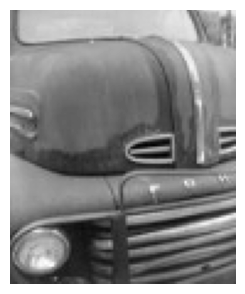

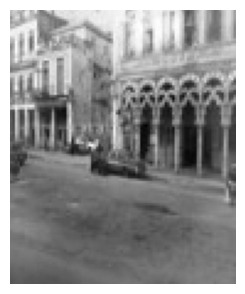

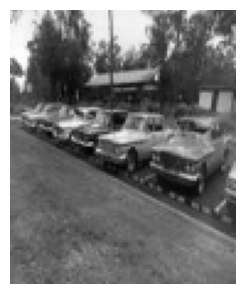

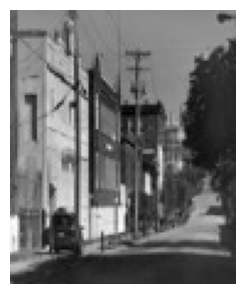

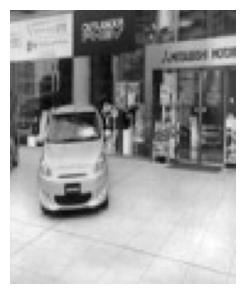

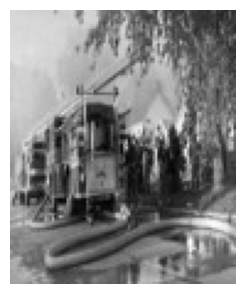

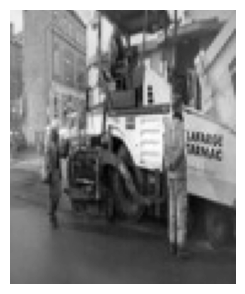

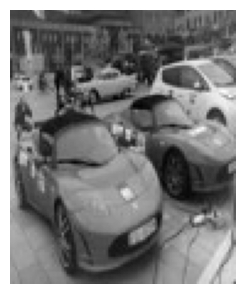

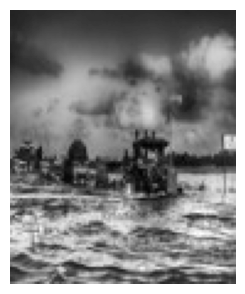

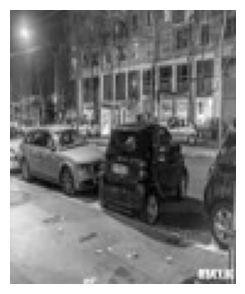

_____________________________________________________________________
PCA
faces vs non_faces:
non faces training size:  100  accuracy:  0.768
Total successes: 384  / 500
Number of face failures: 0  / 200
Number of non-face failures: 116  / 300
No face failure cases found.
Non-Face Failure Cases:


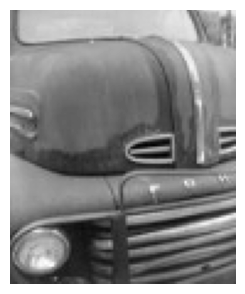

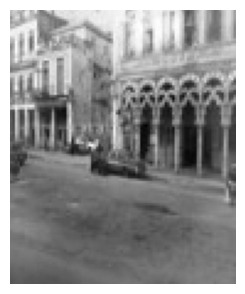

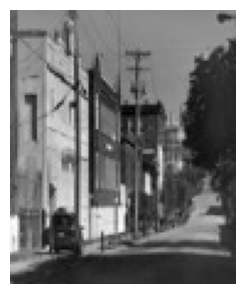

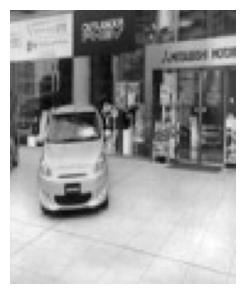

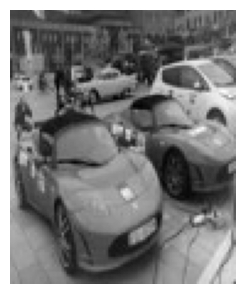

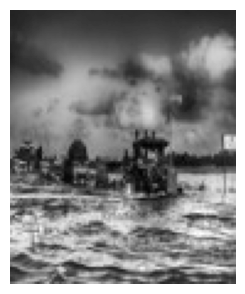

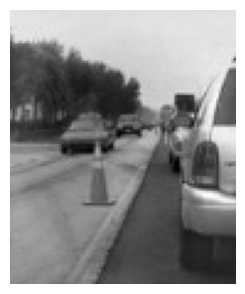

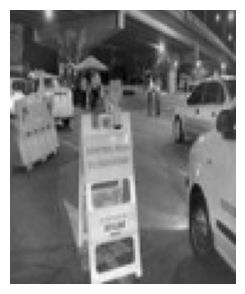

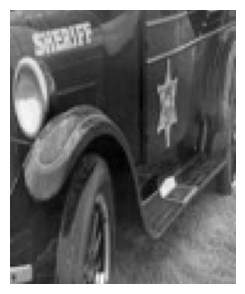

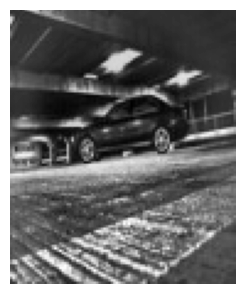

_____________________________________________________________________
PCA
faces vs non_faces:
non faces training size:  200  accuracy:  0.928
Total successes: 464  / 500
Number of face failures: 0  / 200
Number of non-face failures: 36  / 300
No face failure cases found.
Non-Face Failure Cases:


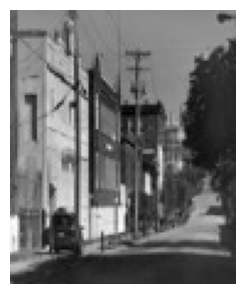

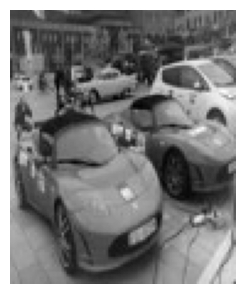

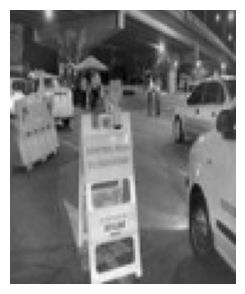

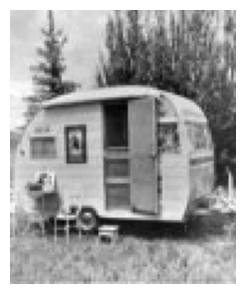

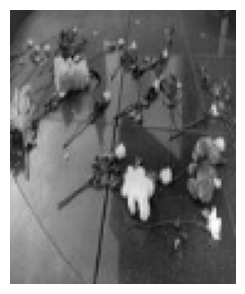

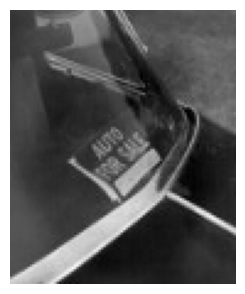

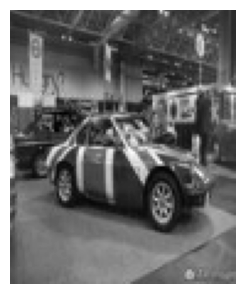

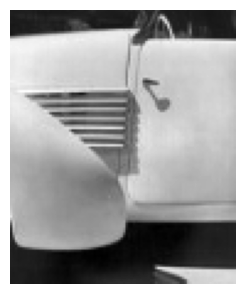

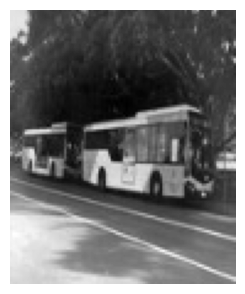

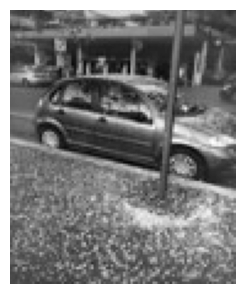

_____________________________________________________________________
PCA
faces vs non_faces:
non faces training size:  300  accuracy:  0.966
Total successes: 483  / 500
Number of face failures: 0  / 200
Number of non-face failures: 17  / 300
No face failure cases found.
Non-Face Failure Cases:


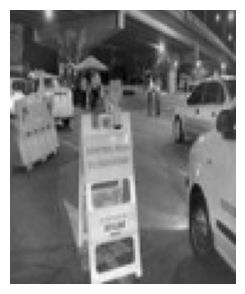

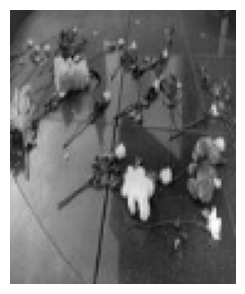

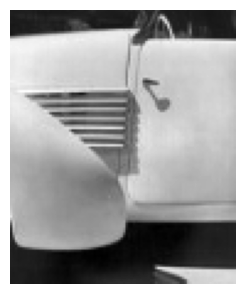

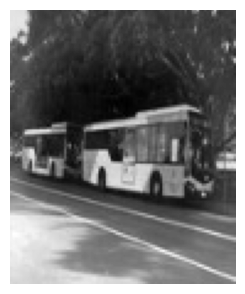

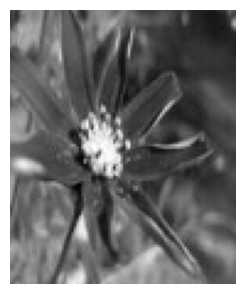

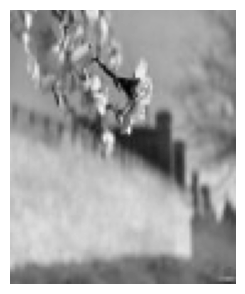

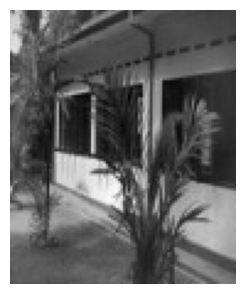

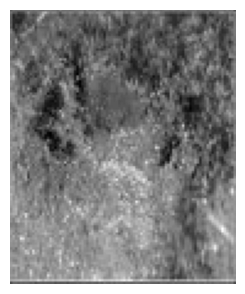

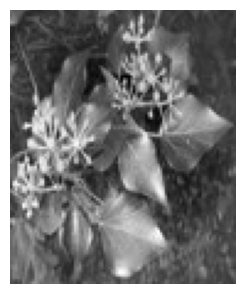

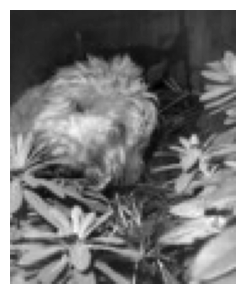

_____________________________________________________________________
PCA
faces vs non_faces:
non faces training size:  400  accuracy:  0.974
Total successes: 487  / 500
Number of face failures: 0  / 200
Number of non-face failures: 13  / 300
No face failure cases found.
Non-Face Failure Cases:


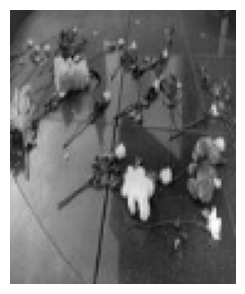

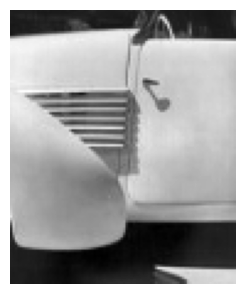

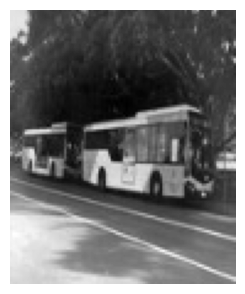

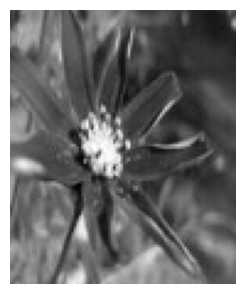

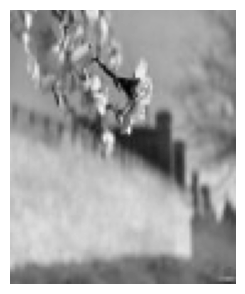

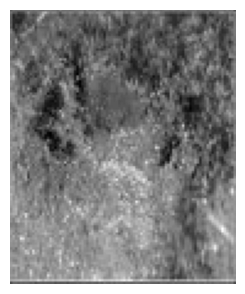

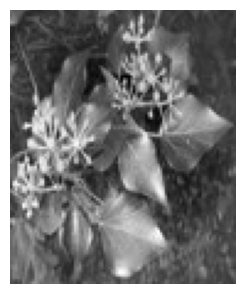

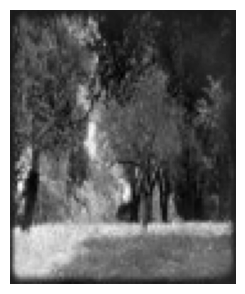

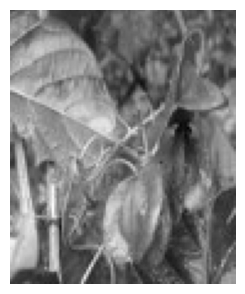

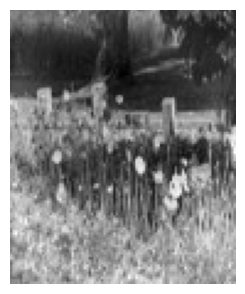

_____________________________________________________________________
PCA
faces vs non_faces:
non faces training size:  600  accuracy:  0.992
Total successes: 496  / 500
Number of face failures: 1  / 200
Number of non-face failures: 3  / 300
Face Failure Cases:


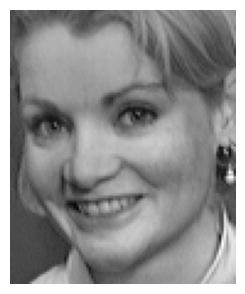

Non-Face Failure Cases:


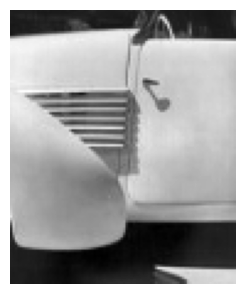

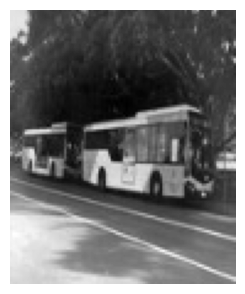

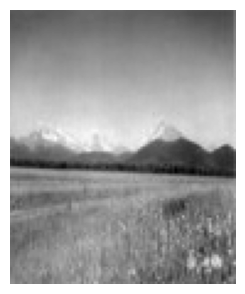

_____________________________________________________________________


In [ ]:
# run PCA with display
# non_face_training_sizes = [50, 100, 200, 300, 400, 600]
# for training_size in non_face_training_sizes:
#     faces_vs_non_faces(training_size, 300, True, True)

In [ ]:
# run LDA with display
# non_face_training_sizes = [50, 100, 200, 300, 400, 600]
# for training_size in non_face_training_sizes:
#     faces_vs_non_faces(training_size, 300, False, True)

In [ ]:
# run PCA without display
# non_face_training_sizes = [50, 100, 200, 300, 400, 600]
# for training_size in non_face_training_sizes:
#     faces_vs_non_faces(training_size, 300, True, False)

PCA
faces vs non_faces:
non faces training size:  50  accuracy:  0.596
Total successes: 298  / 500
Number of face failures: 0  / 200
Number of non-face failures: 202  / 300
_____________________________________________________________________
PCA
faces vs non_faces:
non faces training size:  100  accuracy:  0.768
Total successes: 384  / 500
Number of face failures: 0  / 200
Number of non-face failures: 116  / 300
_____________________________________________________________________
PCA
faces vs non_faces:
non faces training size:  200  accuracy:  0.928
Total successes: 464  / 500
Number of face failures: 0  / 200
Number of non-face failures: 36  / 300
_____________________________________________________________________
PCA
faces vs non_faces:
non faces training size:  300  accuracy:  0.966
Total successes: 483  / 500
Number of face failures: 0  / 200
Number of non-face failures: 17  / 300
_____________________________________________________________________
PCA
faces vs non_faces:
non

In [ ]:
# run LDA without display
# non_face_training_sizes = [50, 100, 200, 300, 400, 600]
# for training_size in non_face_training_sizes:
#     faces_vs_non_faces(training_size, 300, False, False)

LDA
faces vs non_faces:
non faces training size:  50  accuracy:  0.562
Total successes: 281  / 500
Number of face failures: 0  / 200
Number of non-face failures: 219  / 300
_____________________________________________________________________
LDA
faces vs non_faces:
non faces training size:  100  accuracy:  0.746
Total successes: 373  / 500
Number of face failures: 0  / 200
Number of non-face failures: 127  / 300
_____________________________________________________________________
LDA
faces vs non_faces:
non faces training size:  200  accuracy:  0.906
Total successes: 453  / 500
Number of face failures: 2  / 200
Number of non-face failures: 45  / 300
_____________________________________________________________________
LDA
faces vs non_faces:
non faces training size:  300  accuracy:  0.92
Total successes: 460  / 500
Number of face failures: 6  / 200
Number of non-face failures: 34  / 300
_____________________________________________________________________
LDA
faces vs non_faces:
non 

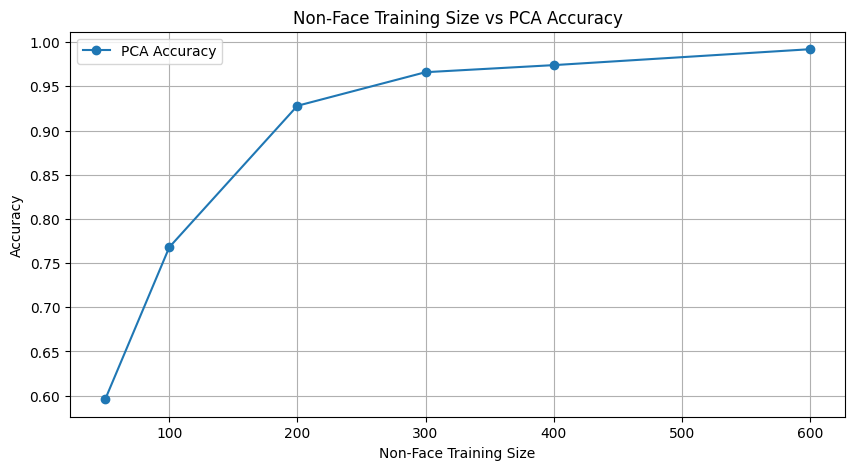

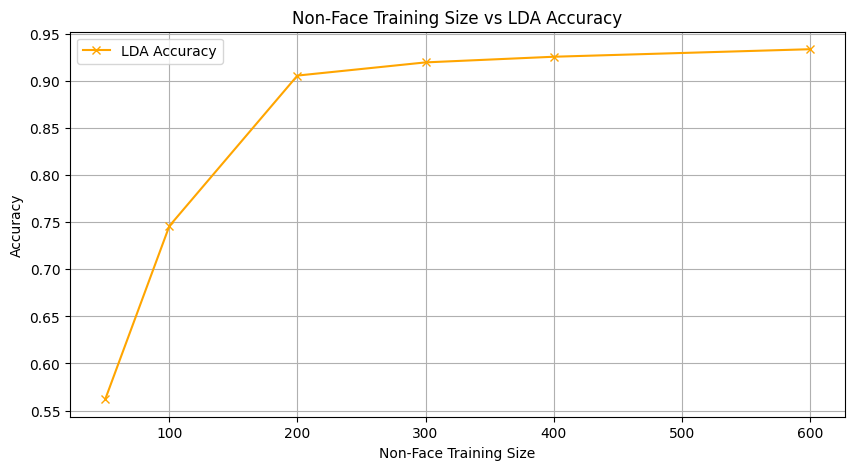

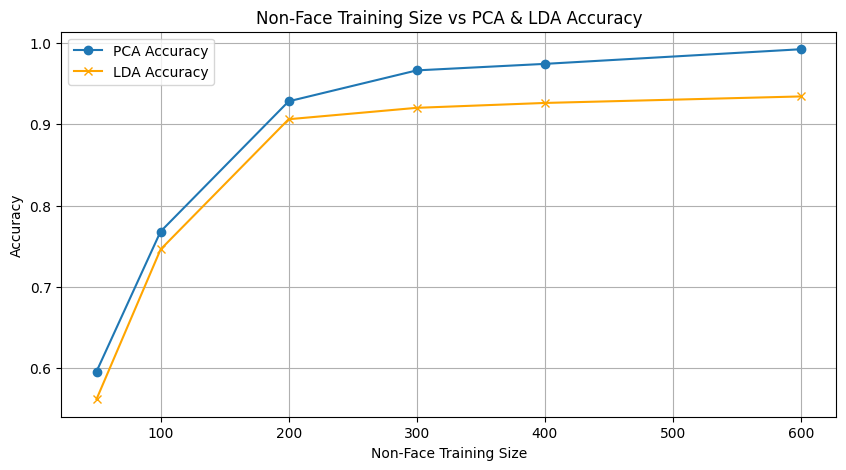

In [ ]:
#Plot the accuracy vs the number of non-faces images while fixing the number of face images.
non_face_training_sizes = [50, 100, 200, 300, 400, 600]
pca_accuracies = []
lda_accuracies = []
for training_size in non_face_training_sizes:
    pca_accuracies.append(faces_vs_non_faces(training_size, 300, True, False))

for training_size in non_face_training_sizes:
    lda_accuracies.append(faces_vs_non_faces(training_size, 300, False, False))

# Plot PCA accuracy
plt.figure(figsize=(10, 5))
plt.plot(non_face_training_sizes, pca_accuracies, marker='o', label='PCA Accuracy')
plt.xlabel('Non-Face Training Size')
plt.ylabel('Accuracy')
plt.title('Non-Face Training Size vs PCA Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot LDA accuracy
plt.figure(figsize=(10, 5))
plt.plot(non_face_training_sizes, lda_accuracies, marker='x', color='orange', label='LDA Accuracy')
plt.xlabel('Non-Face Training Size')
plt.ylabel('Accuracy')
plt.title('Non-Face Training Size vs LDA Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot both PCA and LDA accuracies
plt.figure(figsize=(10, 5))
plt.plot(non_face_training_sizes, pca_accuracies, marker='o', label='PCA Accuracy')
plt.plot(non_face_training_sizes, lda_accuracies, marker='x', color='orange', label='LDA Accuracy')
plt.xlabel('Non-Face Training Size')
plt.ylabel('Accuracy')
plt.title('Non-Face Training Size vs PCA & LDA Accuracy')
plt.legend()
plt.grid(True)
plt.show()

iv. Criticize the accuracy measure for large numbers of non-faces
images in the training data.
* we can notice that when increasing the number of non faces in the training data accuracy increased as expected as the model had more data to learn from and can better differenciate between face and no face.
* With a large number of non-faces images compared to face images, the dataset becomes imbalanced. Accuracy, which simply measures the proportion of correctly classified instances, can be misleading in imbalanced datasets. for example a classifier that always predicts the majority class (non-face in this case) can achieve high accuracy, but it may fail to detect faces effectively.
* High accuracy might hide the classifier's poor performance on the minority class (faces). For example, if the classifier correctly identifies 99% of non-faces but only 50% of faces, the overall accuracy may still be high, but the classifier is not effective at recognizing faces.



---



## **B.Bonus**

a. Use different Training and Test splits. Change the number of instances per subject to be 7 and keep 3 instances per subject for testing. compare the results you have with the ones you got earlier with 50% split.

In [ ]:
def get_diff_training_test(data, label):
    training_data = []
    training_label = []
    testing_data = []
    testing_label = []

    for i in range(40):
        start_idx = i * 10  # Starting index for the i-th subject
        end_idx = start_idx + 7  # Ending index for training data
        training_data.extend(data[start_idx:end_idx])
        training_label.extend(label[start_idx:end_idx])

        start_idx = start_idx + 7  # Starting index for testing data
        end_idx = start_idx + 3  # Ending index for testing data
        testing_data.extend(data[start_idx:end_idx])
        testing_label.extend(label[start_idx:end_idx])

    return training_data, training_label, testing_data, testing_label

PCA time: 2.263244152069092  sec
PCA time: 1.380629062652588  sec
PCA time: 1.3338463306427002  sec
PCA time: 1.6183416843414307  sec
PCA time: 1.2331581115722656  sec
PCA time: 0.5904800891876221  sec
PCA time: 0.5679047107696533  sec
PCA time: 0.5745677947998047  sec
PCA time: 0.5355801582336426  sec
PCA time: 0.9892871379852295  sec
PCA time: 1.788642168045044  sec
PCA time: 1.6902110576629639  sec
PCA time: 0.9682226181030273  sec
PCA time: 0.9563901424407959  sec
PCA time: 0.9731757640838623  sec
PCA time: 0.984128475189209  sec
PCA time: 0.9760351181030273  sec
PCA time: 0.962785005569458  sec


PCA tabulated results:
   alpha Value  50% split Accuracy  70% - 30% split Accuracy
0         0.60               0.905                  0.941667
1         0.65               0.915                  0.950000
2         0.70               0.920                  0.950000
3         0.75               0.925                  0.950000
4         0.80               0.930                  0.958333
5 

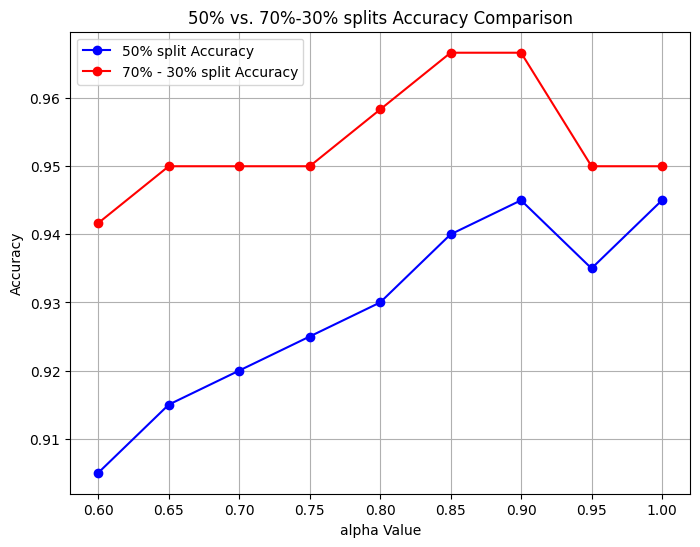

In [ ]:
#PCA comparison
# 50% split
alpha = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1]
half_split_accuracy = alpha_compare()
# 70% - 30% splits
diff_split_accuracy = alpha_compare(isHalf=False)

print("\n\nPCA tabulated results:")
# Create a pandas DataFrame to display the results
results_df = pd.DataFrame({
    'alpha Value': alpha,
    '50% split Accuracy': half_split_accuracy,
    '70% - 30% split Accuracy': diff_split_accuracy
})

# Print the DataFrame
print(results_df)

# accuracies together
plt.figure(figsize=(8, 6))
plt.plot(alpha, half_split_accuracy, marker='o', label='50% split Accuracy', color='blue')
plt.plot(alpha, diff_split_accuracy, marker='o', label='70% - 30% split Accuracy', color='red')
plt.title('50% vs. 70%-30% splits Accuracy Comparison')
plt.xlabel('alpha Value')
plt.ylabel('Accuracy')
plt.xticks(alpha)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#LDA comparison
# print("LDA accuracy comparison")
# print("50% split Accuracyacy: ", test_lda([1])[0])
# print("70%-30% splits Accuracy: ", test_lda([1], isHalf=False)[0])

LDA accuracy comparison
50% split Accuracyacy:  0.96
70%-30% splits Accuracy:  0.95


<p>What is interesting about using different splits that the accuaracy of classification has increased. We used a larger number of samples to be the training set which contributed to a higher accuracy as displayed in the previous plot</p>


b. [10 points] There are other variations of PCA and LDA beyond the
original algorithms. Please use one of the variations of PCA and one
variations of LDA other than the original ones. Compare the time
complexity and accuracy between the 2 different PCA and LDA
models.

# **Kernel PCA**

Kernel PCA is an extension of PCA that allows for non-linear dimensionality reduction. It's particularly useful when the data is not linearly separable in the original feature space. The key idea behind Kernel PCA is to implicitly map the input data into a higher-dimensional space where it becomes linearly separable, perform PCA in this new space, and then map the results back to the original space.

## Difference between PCA and Kernel PCA

The main difference between PCA and Kernel PCA lies in their ability to handle non-linear relationships in the data. PCA works well for linear relationships but may not capture the underlying structure in non-linear data. Kernel PCA, on the other hand, can capture non-linear relationships by implicitly mapping the data into a higher-dimensional space using a kernel function.

## How Kernel PCA Works

1. **Choose a Kernel**: Select a suitable kernel function (e.g., Gaussian, polynomial) that measures the similarity between pairs of data points. Common choices include the Gaussian (RBF) kernel and the polynomial kernel.

2. **Compute the Kernel Matrix**: Calculate the pairwise kernel values for all data points. This forms the kernel matrix.

3. **Center the Kernel Matrix**: Center the kernel matrix to make the data zero-mean in the feature space.

4. **Eigenvalue Decomposition**: Perform eigenvalue decomposition on the centered kernel matrix to obtain the eigenvectors and eigenvalues.

5. **Select Principal Components**: Choose the top-k eigenvectors (principal components) corresponding to the k largest eigenvalues.

6. **Project Data**: Project the original data onto the new subspace formed by the selected principal components.

## The Importance of Kernel Matrix in Kernel PCA

The kernel matrix computed using a kernel function represents the pairwise similarities or distances between data points in a transformed feature space induced by the kernel function.

**Reasons why the kernel matrix is useful in kPCA:**

1. **Implicit Mapping**: The kernel matrix implicitly represents the transformed data in a higher-dimensional space without explicitly computing the transformed feature vectors.

2. **Eigenvalue Decomposition**: The kernel matrix serves as the input for the eigenvalue decomposition step in kPCA.

3. **Nonlinear Relationships**: The kernel matrix captures the nonlinear relationships between data points, allowing kPCA to identify nonlinear structures in the data.

## Computing Kernel Matrix for Kernel PCA:

1. **Compute Pairwise Inner Products**:
   - Compute inner products between all pairs of data points.

2. **Apply Polynomial Kernel Function**:
   - Use the polynomial kernel function:
     K(xi,xj)=(xi⋅xj+c)^deg

3. **Form the Kernel Matrix**:
   - Construct the kernel matrix
   Kij = K(xi,xj)
   - Results in an n*n symmetric matrix.
   

## Time Complexity Comparison:

- **PCA**:
  - Computation of Covariance Matrix: \( O(nd^2) \)
  - Eigenvalue Decomposition: \( O(d^3) \)
  - Overall Time Complexity: \( O(nd^2 + d^3) \)

- **Kernel PCA**:
  - Computation of Kernel Matrix: \( O(n^2d) \)
  - Eigenvalue Decomposition: \( O(n^3) \)
  - Overall Time Complexity: \( O(n^2d + n^3) \)

## Accuracy Comparison:

- **PCA**:
  - Suitable for linear relationships in data.
  - May not capture underlying nonlinear structures well.

- **Kernel PCA**:
  - Suitable for nonlinear relationships in data.
  - Captures nonlinear structures effectively.

- For this specific data set PCA accuracy was 0.945 when alpha = 0.9 or 1 while KPCA accuracy when degree is 1 is 0.945 and decreases to 0.935 and 0.93 when degree is 2 and 3.

### Conclusion:

- Use PCA for linear relationships.
- Use Kernel PCA for nonlinear relationships.
---

In [ ]:
def test_kernel_pca(k, degree):
    D, y = generate_data_label(archive)
    D_training, y_training, D_testing, y_testing = get_training_and_test(D, y)
    start = time.time()
    #Use KernelPCA
    kpca = sklearn.decomposition.KernelPCA(kernel='poly',degree=degree)
    projected_D_training = kpca.fit_transform(D_training)
    projected_D_testing = kpca.transform(D_testing)
    end = time.time()

    print("Kernel PCA time:", (end - start), " sec")

    # KNN classification
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(projected_D_training, y_training)
    y_pred = knn_classifier.predict(projected_D_testing)
    accuracy = knn_classifier.score(projected_D_testing, y_testing)
    return accuracy

Kernel PCA time: 0.21476316452026367  sec
Kernel PCA time: 0.16202783584594727  sec
Kernel PCA time: 0.17963600158691406  sec
Kernel PCA time: 0.15717315673828125  sec
Kernel PCA time: 0.15989041328430176  sec


KPCA tabulated results:
   Degree Value  Accuracy
0             1     0.945
1             2     0.935
2             3     0.930
3             4     0.925
4             5     0.920


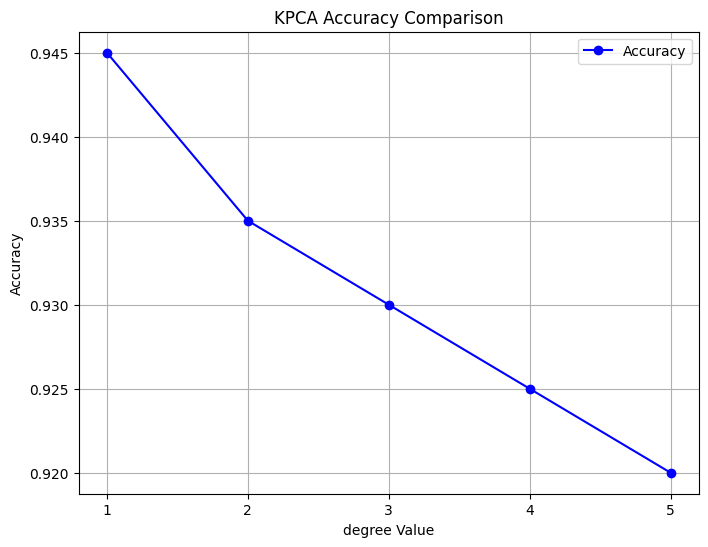

In [ ]:
degrees = [1, 2, 3, 4, 5]
kpca_accuracy = []
for degree in degrees:
  accuracy = test_kernel_pca(1, degree)
  kpca_accuracy.append(accuracy)

print("\n\nKPCA tabulated results:")
# Create a pandas DataFrame to display the results
results_df = pd.DataFrame({
    'Degree Value': degrees,
    'Accuracy': kpca_accuracy,
})

# Print the DataFrame
print(results_df)

# accuracies together
plt.figure(figsize=(8, 6))
plt.plot(degrees, kpca_accuracy, marker='o', label='Accuracy', color='blue')
plt.title('KPCA Accuracy Comparison')
plt.xlabel('degree Value')
plt.ylabel('Accuracy')
plt.xticks(degrees)
plt.grid(True)
plt.legend()
plt.show()


from the previous we can note that:
* As the degree of the polynomial kernel increases, the accuracy of the KPCA model tends to decrease.
* The accuracy decreases from 0.945 at degree 1 to 0.920 at degree 5.
* Higher degrees of polynomial kernels introduce higher levels of non-linearity into the feature space. While this increased complexity can sometimes capture intricate patterns in the data, it can also lead to overfitting.
* Overfitting occurs when the model captures noise and random fluctuations in the training data, which do not generalize well to unseen data, resulting in reduced accuracy.


# **Quadratic Discriminant Analysis (QDA)**

#### **Definition:**
Quadratic Discriminant Analysis (QDA) is a supervised classification algorithm used for modeling and classifying data points based on their features. In QDA, it is assumed that the class-conditional densities of the features follow multivariate Gaussian distributions, with each class potentially having its own covariance matrix.


#### **Difference from LDA:**
The main difference between QDA and Linear Discriminant Analysis (LDA) lies in their assumptions about the covariance matrices. While LDA assumes that all classes share a common covariance matrix, QDA relaxes this assumption and allows each class to have its own covariance matrix. This flexibility enables QDA to capture more complex relationships between features within each class.


#### **How it Works:**
1. **Parameter Estimation**: QDA estimates the parameters of the Gaussian distributions for each class, including the mean vector and covariance matrix.
2. **Decision Boundary**: QDA computes the decision boundary between classes based on the class-conditional densities. Since QDA allows for different covariance matrices for each class, the decision boundary can be nonlinear, resulting in a quadratic decision boundary.
3. **Classification**: Given a new data point, QDA assigns it to the class with the highest class-conditional density, computed using the estimated parameters.


#### **Time Complexity Comparison:**
- **LDA**: Time complexity for LDA is approximately **\( O(nd^2 + d^3) \)**, where \( n \) is the number of samples and \( d \) is the number of features.
- **QDA**: Time complexity for QDA can be similar to LDA but may involve additional computations due to the estimation of separate covariance matrices for each class.


#### **Accuracy Comparison:**


*   Since in QDA each class will have its Gaussian distribution so we'shall have a large number of samples for each class to train the model in order to form a good Gaussian distribution.
*   But here since we have small number of instances for each label (in our basic model there's 5 samples for each person), they're not enough to capture the PDF for the class so we'll see that the accuacy for it is so small nearly **12%**, unlike LDA that can predict the label well enough given the available set to train the model


In [ ]:
def test_qda():
    D, y = generate_data_label(archive)
    D_training, y_training, D_testing, y_testing = get_training_and_test(D, y)

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to your training data and transform it
    D_training = scaler.fit_transform(D_training)

    # Apply the same transformation to your testing data
    D_testing = scaler.transform(D_testing)

    start = time.time()
    #Use Quadratic Discriminant Analysis through sickit-learn
    qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
    qda.fit(D_training,y_training)
    prediction = qda.predict(D_testing)

    return qda.score(D_testing,y_testing)

In [ ]:
# print("QDA accuracy: ", test_qda())

# print("LDA accuracy: ", test_lda([1])[0])

QDA accuracy:  0.12
LDA accuracy:  0.96


# **Regularized Linear Discriminant Analysis (rLDA)**

#### **Definition:**
Regularized Linear Discriminant Analysis (rLDA) is an extension of the traditional Linear Discriminant Analysis (LDA) algorithm, incorporating regularization techniques to improve the stability and generalization performance of the model. rLDA aims to address potential issues with ill-conditioned covariance matrices, especially in high-dimensional or noisy datasets, by introducing regularization.

#### **Difference between rLDA and LDA:**
- **Regularization**: The main difference between rLDA and LDA lies in the incorporation of regularization in rLDA. While LDA estimates class-specific covariance matrices directly from the data, rLDA applies regularization techniques to stabilize the estimation process and prevent overfitting, particularly when dealing with collinear features or limited sample sizes (which is the case in our case, so we shall expect a high accuracy).

#### **How it Works:**
- **Regularization**: rLDA applies regularization to the estimation of covariance matrices by adding a penalty term to the optimization objective.
- **Optimization**: The regularization parameter controls the strength of regularization, balancing between fitting the training data well and maintaining stability.
- **Parameter Estimation**: rLDA estimates the class-specific means and regularized covariance matrices from the training data.
- **Classification**: During classification, rLDA uses Bayes' theorem to compute posterior probabilities for each class and assigns the input data point to the class with the highest probability.

#### **Time Complexity Comparison:**
- **rLDA vs. LDA**: The time complexity of rLDA and LDA is generally similar **\( O(nd^2 + d^3) \)**, where \( n \) is the number of samples and \( d \) is the number of features since both algorithms involve computing means and covariance matrices from the training data, followed by classification using these parameters. However, the computational cost of rLDA may be slightly higher due to the additional regularization step.

#### **Applicapility**:
- **When to Apply rLDA**: rLDA is particularly useful when dealing with high-dimensional datasets with a large number of features relative to the number of samples or when the data contains collinear features.
- **Benefits of rLDA**: rLDA can help improve the stability and generalization performance of the model, especially in scenarios where LDA may suffer from overfitting or instability due to ill-conditioned covariance matrices.

#### **Conclusion:**
- Regularized Linear Discriminant Analysis (rLDA) offers a robust and stable alternative to traditional LDA, especially in situations where regularization is necessary to mitigate issues with collinearity, high dimensionality, or noisy data.
- By incorporating regularization techniques, rLDA provides a balance between model complexity and stability, leading to improved performance and generalization on diverse datasets.



In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def test_rlda( shrinkage_amount, isHalf=True):

    D, y = generate_data_label(archive)
    D_training, y_training, D_testing, y_testing = get_training_and_test(D, y)

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to your training data and transform it
    X_train_scaled = scaler.fit_transform(D_training)

    # Apply the same transformation to your testing data
    X_test_scaled = scaler.transform(D_testing)

    # Getting the basis of the new space
    start = time.time()

    # Use rLDA instead of LDA with automatic shrinkage
    rlda = LinearDiscriminantAnalysis(solver='eigen', shrinkage=shrinkage_amount)
    rlda.fit(X_train_scaled, y_training)
    end = time.time()

    print("Time taken to compute Ur = ", (end - start) / 60.0 ," mins")

    # Transform the data using the learned rLDA projection
    X_train_rlda = rlda.transform(X_train_scaled)
    X_test_rlda = rlda.transform(X_test_scaled)

    # Predict labels for testing data
    y_pred = rlda.predict(X_test_scaled)

    # Compute accuracy
    accuracy = (y_pred == y_testing).mean()



    return accuracy

In [ ]:
# print("==============================The RLDA accuracy for different shrinkage value=================================")
# shrinkage_amounts = ['0.1', '0.25', '0.5', '0.75', '0.9', '1', 'auto']

# for shrinkage in shrinkage_amounts:
#   acc = test_rlda(shrinkage_amount=shrinkage)
#   print("Accuracy of rLDA with Shrinkage = ", acc)
#   print(acc)

# print(x)

# print("==============================The LDA accuracy==================================================")
# print("LDA accuracy: ", test_lda([1])[0])

==============================The RLDA accuracy for different shrinkage value=================================

Time taken to compute Ur = 74.0493055065473 mins
Accuracy of rLDA with Shrinkage = 0.1
0.97

Time taken to compute Ur = 58.02694724798202 mins
Accuracy of rLDA with Shrinkage = 0.25
0.97

Time taken to compute Ur = 9.734944272041322 mins
Accuracy of rLDA with Shrinkage = 0.5
0.975

Time taken to compute Ur = 9.659004700183868 mins
Accuracy of rLDA with Shrinkage = 0.75
0.975

Time taken to compute Ur = 9.513030862808227 mins
Accuracy of rLDA with Shrinkage = 0.9
0.965

Time taken to compute Ur = 9.650418901443482 mins
Accuracy of rLDA with Shrinkage = 1
0.885

Time taken to compute Ur = 13.49125273625056 mins
Accuracy of rLDA with Shrinkage = auto
0.985

==============================The LDA accuracy==================================================
LDA accuracy:  0.96
